## Install and import dependencies

In [5]:
!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 19.1MB 46.4MB/s 


In [12]:
#!/usr/bin/env python
# coding: utf-8

# In[7]:
import os
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import cv2
import rasterio as rio
import pycocotools.mask as mask_util
import shapely
import math
import numpy as np
import json
from shapely.geometry import Polygon, Point
from osgeo import gdal
import csv
import pandas as pd
import rasterio.mask
import fiona
from PIL import Image, ImageEnhance
from skimage import measure


## Post Processing Class

In [18]:
#!/usr/bin/env python
# coding: utf-8

class Post_Process:
    def __init__(self, coco_file , tif_img, img_name, threshold, crs_value='EPSG:4326'):
        '''
        class takes model prediction (coco json format) c
        and reference image, for post processing
        Returns, binary mask and dataframe with area and oriantation
        '''
        self.coco_file = coco_file
        self.tif_img = tif_img
        self.geo_df = None
        self.bin_mask = None
        self.result_dict = []
        self.img_name = img_name
        self.threshold = threshold
        self.crs_value = crs_value
        
    
    def get_full_post_process(self):
        ''' Full post process mask
        Returns, Tuple (binary mask and dataFrame)'''
        self.bin_mask = self.get_bin_mask()
        self.geo_df = self.get_px_coords_df()
        #self.geo_df = self.get_px_coords()
        self.geo_df = self.get_geo_coords()
        self.geo_df = self.get_lat_long()
        self.geo_df = self.get_area()
        self.geo_df = self.get_azimuth()

       
    
        # Return the binary mask and the geo dataframe 
        return  self.bin_mask, self.geo_df
        
    
    def get_bin_mask(self):
        '''Decods the model prediction in Json format with the encoded masks
        Retruns the binary mask '''
        ## Read and parse our json file
        with open(self.coco_file, 'r') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
        
        #poly_loc_list = []
        ## iterate and decode segmentations
        self.bin_mask = np.zeros(obj[0]['segmentation']['size'])

        for i in range(len(obj)):
            # Check the prediction score
            if obj[i]['score'] > self.threshold:
                seg_dict = {}
                seg_dict = {'size': obj[i]['segmentation']['size'], 'counts' : obj[i]['segmentation']['counts']}
        
                poly = mask_util.decode(seg_dict)[:, :]
            
                self.bin_mask += poly
            
        return  self.bin_mask
    
    def calc_azimuth(self, g):
        '''takes a geometry  and returns the angle'''        
        a = g.minimum_rotated_rectangle
        l = a.boundary
        coords = [c for c in l.coords]
        segments = [shapely.geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]
        longest_segment = max(segments, key=lambda x: x.length)

        p1, p2 = [c for c in longest_segment.coords]
        angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
        return angle
    
    def get_area(self):
        '''
        calculate area for our polygons and append to the geo_df
        '''
        # reproject to meter coordinates
        self.geo_df = self.geo_df.to_crs('EPSG:5703')
        # If it we have the df
        # Get the area and append to the df
        if self.geo_df is not None :
            # Calculate the area
            self.geo_df['area(square meter)'] = ((self.geo_df['geometry'].area)) # In sequare meter #/10.764
            # Back to original 
            self.geo_df = self.geo_df.to_crs(self.crs_value)
        else:
            print("No dataframe acquired, yet. Use get_geo_df")
        
        return self.geo_df
    
    
    def get_azimuth(self):
        '''Calculate the azimuth angle'''
        # Make sure we already have the geo_df calculated
        list_azimuth = []
        if self.geo_df is not None :
            for i in range(len(self.geo_df)):
                g = self.geo_df.iloc[i].geometry
                angle = self.calc_azimuth(g)
                list_azimuth.append(angle)
                
            self.geo_df['Roof_Azimuth'] = list_azimuth
        
        else: 
             print("No dataframe acquired, yet. Use get_geo_df")
        
        return self.geo_df
    
    def get_px_coords_df(self):
        '''Convert ourbinary mask to polygons'''
        
        if self.bin_mask is not None:
            contours = measure.find_contours(self.bin_mask, 0.5)
            len(contours)
            px_polys = []
            for contour in contours:
                #poly.is_valid
                poly = Polygon(contour).simplify(1.0)
                if poly.is_valid:
                    px_polys.append(poly)

            data = []
            for i in range(len(px_polys)):
                data_dict = {}
                data_dict = {'value': i, 'geometry' :px_polys[i]}
                data.append(data_dict)

            # Create dataFrame
            self.geo_df = gpd.GeoDataFrame(data)
            
        else:
            print("Claclulate binary mask first using get_bin_mask")
        
        self.geo_df = self.geo_df.drop(['value'], axis = 1) 
        return self.geo_df
    
    '''def get_px_coords_df(self):
        if self.bin_mask is not None:
            
            self.geo_df = sol.vector.mask.mask_to_poly_geojson(pred_arr=self.bin_mask, 
                                                 reference_im=self.tif_img,  
                                                 min_area=1, simplify=True) #min_area=1
            
            self.geo_df = self.geo_df.drop(['value'], axis = 1) 
            
            
        else:
            print("Claclulate binary mask first using get_bin_mask")
            
        return self.geo_df'''
    
    def get_px_coords(self):
        """Function to get geo coordinates given a pixel coordinates"""
        xs_list = []
        ys_list = []
        # Get thelist of pixel lat/long
       # First we get the pixel lat/long values
        self.geo_df['pixel_Center_point'] = self.geo_df['geometry'].centroid
        #Extract lat and lon from the centerpoint
        self.geo_df["pixel_x"] = self.geo_df.pixel_Center_point.map(lambda p: p.x)
        self.geo_df["pixel_y"] = self.geo_df.pixel_Center_point.map(lambda p: p.y)
              
        return self.geo_df
    
    def get_geo_coords(self):
        '''Convert the each pixel point 
        to a georefrenced point with lat/long coordinates'''
        # Now convert the pixel row/col to lat/long
        # unravel GDAL affine transform parameters
        coords = [list(poly.exterior.coords) for poly in self.geo_df.geometry]
        geo_poly = []
        geo_coords = []

        for poly in coords:
            geo_poly = []
            #print(poly)
            for points in poly:
                x = points[0]
                y = points[1]
        
                (px, py) = rio.transform.xy(self.tif_img.transform, x, y, offset='center')
                poly = (px, py)
                geo_poly.append(poly)
        
            geo_coords.append(geo_poly)
    
        geo_polys = []    
        for poly in geo_coords:
            geo_polys.append(Polygon(poly))
        
        # Add the new polygons to our gdf
        #self.geo_df['px_polygonss'] = self.geo_df['geometry'] # The old pixel polygons
        self.geo_df['geometry'] = geo_polys # assign the new polygons
        self.geo_df = self.geo_df.set_crs(self.crs_value) #'EPSG:4326'
        return self.geo_df
    
    def get_lat_long(self):
        """Function to get coordinates in latitude and longitude degress as a column in dataframe"""
        # reproject to meter coordinates
        self.geo_df = self.geo_df.to_crs('EPSG:5703')
        # Find the center of the polygons
        self.geo_df['points'] = self.geo_df['geometry'].centroid
        #Extract lat and lon from the centerpoint (This is extra)
        self.geo_df["latitude"] = self.geo_df.points.map(lambda p: p.x)
        self.geo_df["longitude"] = self.geo_df.points.map(lambda p: p.y)
        #self.geo_df = self.geo_df.drop(['center_point', 'polygons', 'pix_polygons', 'pixel_Center_point'], axis = 1)
        # Back to original crs
        self.geo_df = self.geo_df.to_crs(self.crs_value)
        return self.geo_df
    
    
    # Append the information to our json file and save it somewhere
    def append_to_json(self, filename):
        '''takes a ../filename.json and 
        save the dictionary with all the information
        in a JSON file on disk'''
        ## Read and parse our json file
        with open(self.coco_file, 'r') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
        
        #poly_loc_list = []
        ## iterate and decode segmentations
        self.bin_mask = np.zeros(obj[0]['segmentation']['size'])
        
        for i in range(len(self.geo_df)):
            # Check the prediction score
            if obj[i]['score'] >= self.threshold:
                seg_dict = {}
                seg_dict = {'size': obj[i]['segmentation']['size'], 'counts' : obj[i]['segmentation']['counts']}
        
                poly = mask_util.decode(seg_dict)[:, :]
                seg_dict = {}
                seg_dict = {'size': obj[i]['segmentation']['size'], 'counts' : obj[i]['segmentation']['counts']}
                poly = mask_util.decode(seg_dict)[:, :]
                poly = poly.tolist()
                 # Create new Json file to append our information to (this will contains polygons with high scores only)
                new_json = {}
                new_json = {'image_name': self.img_name, 
                            'geometry': (np.asarray(self.geo_df.iloc[i].geometry.exterior.coords)).tolist(),
                            'longitude': self.geo_df.iloc[i].longitude, 
                            'latitude':self.geo_df.iloc[i].latitude, 
                            'area(square meter)': self.geo_df.iloc[i]['area(square meter)'],
                            'Roof_Azimuth':self.geo_df.iloc[i].Roof_Azimuth}
                
                self.result_dict.append(new_json)
                
        all_json_list = []
        with open(self.coco_file, 'r+') as my_file:
            data = my_file.readlines()
            # Parse file
            obj = json.loads(data[0])
        for i in range(len(self.geo_df)):
            if obj[i]['score'] >= self.threshold: 
                dict_copy = obj[i].copy()
                # Update the dictionary
                dict_copy.update(self.result_dict[i])
                all_json_list.append(dict_copy)
                
                with open(filename, 'w') as outfile:
                    json.dump(all_json_list, outfile)
                    
        
    # Helper method to save our list of dictionaries as a csv file
    def save_to_csv(self, file_name):
        '''Takes a file name with csv extension'''
        keys = self.result_dict[0].keys()
        with open(file_name, 'w', newline='')  as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows( self.result_dict)





## Where the magic happens

In [19]:
# Test our pipeline
img_name = 'SN2_buildings_train_AOI_2_Vegas_PS-RGB_img101.tif'

image = rio.open('/content/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img101.tif')
coco_file = '/content/coco_instances_results (3).json'


In [25]:
obj=Post_Process(coco_file, image, img_name, 0.5)
mask, geo_df_full = obj.get_full_post_process()
geo_df_full.drop(['points'], axis=1, inplace=True)
geo_df_full.to_file("new_geo_df_full.shp")

In [26]:
geo_df_full

,geometry,latitude,longitude,area(square meter),Roof_Azimuth
0,"POLYGON ((-115.30564 36.20718, -115.30566 36.2...",36.207210,-115.305670,6.386496e-09,180.000000
1,"POLYGON ((-115.30436 36.20715, -115.30439 36.2...",36.207175,-115.304366,3.615840e-09,0.000000
2,"POLYGON ((-115.30499 36.20695, -115.30505 36.2...",36.206981,-115.304991,7.869555e-09,9.090277
3,"POLYGON ((-115.30410 36.20684, -115.30412 36.2...",36.206858,-115.304111,1.866240e-09,1.974934
4,"POLYGON ((-115.30573 36.20675, -115.30575 36.2...",36.206777,-115.305716,2.753798e-09,-167.471192
5,"POLYGON ((-115.30567 36.20669, -115.30570 36.2...",36.206726,-115.305639,9.338490e-09,180.000000
6,"POLYGON ((-115.30499 36.20663, -115.30502 36.2...",36.206658,-115.304950,5.698957e-09,-174.685454
7,"POLYGON ((-115.30401 36.20663, -115.30401 36.2...",36.206645,-115.304024,1.250235e-09,90.000000
8,"POLYGON ((-115.30472 36.20654, -115.30474 36.2...",36.206571,-115.304710,3.818137e-09,-175.914383
9,"POLYGON ((-115.30509 36.20652, -115.30512 36.2...",36.206553,-115.305093,4.445533e-09,0.000000


In [27]:
# Save the results in a json format
obj.append_to_json('oco_instances_results (3)_results.json')
obj.save_to_csv('coco_instances_results (3)_results.csv')

In [28]:

with fiona.open("new_geo_df_full.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [29]:
with rasterio.open(img_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes)
crop= out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("RGB.byte.masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [30]:
out_img=rasterio.open('RGB.byte.masked.tif').read(1)

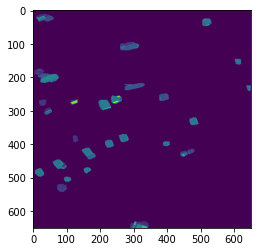

In [31]:
plt.imshow(out_img)

In [32]:
def get_rgb(raster_img):
    '''
      takes a path contaioning mas image 
      and returns the rgb version
      '''
    red = rio.open(raster_img).read(3) 
    green = rio.open(raster_img).read(2) 
    blue = rio.open(raster_img).read(1) 
 
    rgb = np.dstack((red, green, blue))
    # normalize and convert to range 0-255
    rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype('uint8')
    ## Enhance the light
    img = Image.fromarray(rgb)
    enhancer = ImageEnhance.Brightness(img)
    factor = 2.5 #gives original image
    im_output = enhancer.enhance(factor)
    return im_output

In [33]:
buildings_img = get_rgb('RGB.byte.masked.tif')

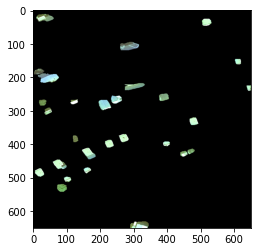

In [34]:
plt.imshow(buildings_img)